##### Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from scipy import stats
from scipy.stats import f, t, chi2

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

import numpy.linalg as la


# Прасинг данных

Мы парсили данные с помощью баблиотеки `scrapy`, поэтому чтобы запустить парсинг нужно:


1. Создать новый проекта Scrapy

```bash
scrapy startproject tsum_parser
```

Эта команда создаст структуру проекта:
```
tsum_parser/
    scrapy.cfg            
    tsum_parser/           
        __init__.py
        items.py         
        middlewares.py   
        pipelines.py     
        settings.py      
        spiders/        
            __init__.py
```

2. Создать паука (spider)

```bash
cd tsum_parser
scrapy genspider tsum_spider https://www.tsum.ru/catalog/sumki-18438/
```

Это создаст файл `tsum_spider.py` в папке `spiders` с базовым шаблоном.

3. Настройка паука

Нужно открыть `tsum_parser/spiders/tsum_spider.py` и вставить код в ячеке ниже.

4. Запуск паука

Нужно выполнить команду для запуска паука и сохранения результатов в json:

```bash
scrapy crawl tsum_spider -o output.json
```


In [11]:
import scrapy
from scrapy.http import Request
from scrapy.utils.response import open_in_browser
import re
from urllib.parse import urljoin
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse, parse_qs, urlencode, urlunparse

class TsumSpider(scrapy.Spider):
    name = 'tsum'
    allowed_domains = ['tsum.ru']
    start_urls = ['https://www.tsum.ru/catalog/sumki-18438/']
    
    custom_settings = {
        'USER_AGENT': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
        'DOWNLOAD_DELAY': 3,
        'CONCURRENT_REQUESTS_PER_DOMAIN': 2,
        'RETRY_TIMES': 3,
        'COOKIES_ENABLED': True,
        'ROBOTSTXT_OBEY': False,
    }
    
    def start_requests(self):
        headers = {
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
            'Accept-Language': 'ru-RU,ru;q=0.8,en-US;q=0.5,en;q=0.3',
            'Referer': 'https://www.tsum.ru/'
        }
        for url in self.start_urls:
            yield Request(url, headers=headers, callback=self.parse_catalog)
    
    def parse_catalog(self, response):
        if response.status != 200:
            self.logger.error(f"Ошибка доступа: {response.status}")
            return
        current_page = response.meta.get('page', 1)
        self.logger.info(f"Обрабатываю страницу #{current_page}")
        
        catalog_div = response.css('div[data-meta-name="catalog"]')
        
        if not catalog_div:
            self.logger.error('div с data-meta-name="catalog" не найден')
            return
        
        product_links = catalog_div.css('a.InternalProductCard__container___C_ZUB[data-meta-name="product"]::attr(href)').getall()
        
        if not product_links:
            self.logger.warning('Не найдено ссылок на товары')
            return
            
        self.logger.info(f"Найдено {len(product_links)} товаров")
        
        for link in product_links:
            absolute_url = urljoin(response.url, link)
            yield Request(
                absolute_url, 
                callback=self.parse_product,
                headers={'Referer': response.url}
            )
            
        next_page = current_page + 1
        next_page_url = f"https://www.tsum.ru/catalog/sumki-18438/?page={next_page}"
        
        if len(product_links) >= 60 and next_page <= 59:  
            yield Request(
                next_page_url,
                callback=self.parse_catalog,
                headers={'Referer': response.url},
                meta={'page': next_page}
            )
        else:
            self.logger.info(f"Достигнут конец каталога на странице {current_page}")

    
    
    def parse_product(self, response):
        if response.status != 200:
            self.logger.error(f"Ошибка доступа к товару: {response.status}")
            return
            
        item = {}
        
        soup = BeautifulSoup(response.text, 'html.parser')
        product_name = soup.find('h1', class_='description__productName___HvN8s')

        if product_name:
            name_text = product_name.get_text()
            item['name'] = name_text
           
        price_div = soup.find('span', attrs={'data-test-id': 'productPrice'})

        price = 0
        if price_div:
            price = str(price_div.get_text(strip=True))  # "1 599 ₽"
            price = price.replace('₽', '')
            price = price.replace('\xa0', '')
            print(int(price))

        sections = soup.find_all('section', class_='SegmentsView__section___jGPx8')
        texts = []
        
        for section in sections:
            list_items = section.find_all('li')
        
            texts = texts + [li.get_text() for li in list_items]
            
        characteristics = {}
        characteristics['price'] = price

        for item_text in texts:
            if ':' not in item_text:
                continue
                
            key, value = map(str.strip, item_text.split(':', 1))
            
            if key == 'Состав':
                value = value.replace(';', '')
            if key == 'Параметры изделия':
                parsed = self.parse_parameters(value)
                characteristics.update(parsed)
            else:
                characteristics[key] = value
                
            
        item['characteristics'] = characteristics
        
        yield item
    
    def parse_parameters(self, value):
        result = {}
        
        size_pattern = r'([А-Яа-я]+)[ :]+(\d+)\s*см'
        sizes = re.findall(size_pattern, value)
        
        kit_match = re.search(r'входит:\s*([^\.]+)', value, re.IGNORECASE)
        
        for name, val in sizes:
            clean_name = name.strip().capitalize()
            result[clean_name] = int(val)
        
        if kit_match:
            result['Комплект'] = kit_match.group(1).strip(' ,')
        
        if 'Ремешка' in result:
            result['Длина ремешка'] = result.pop('Ремешка')
            
        return result

## Код для обработки данных после парсинга

In [ ]:
with open('output.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

data = pd.json_normalize(data)

data = data.dropna()
data = data.rename(columns=lambda x: x.replace('characteristics.', ''))
data['price'] = data['price'].astype(int)
data['is_suitcase'] = data['name'].apply(lambda x: 1 if 'Чемодан' in str(x) else 0)
column_translation = {
    'name': 'name',               
    'price': 'price',               
    'Бренд': 'brand',
    'Цвет': 'color',
    'Состав': 'material',
    'Страна дизайна': 'design_country',
    'Страна производства': 'manufacture_country',
    'Артикул': 'article',
    'Высота': 'height',
    'Ширина': 'width',
    'Глубина': 'depth',
    'Комплект': 'included_items',
    'is_suitcase': 'is_suitcase'    
}
data = data.rename(columns=column_translation)

data.to_csv('bags.csv', index=False)

# Описание данных
 
### 1. Товар
В качестве товара в данной работе рассматриваются сумки и чемоданы.


### 2. Источник данных
Данные были собраны с сайта [ЦУМ](https://www.tsum.ru/) — крупного российского ритейлера люксовых товаров.  
Метод сбора: Парсинг веб-страниц с использованием Python (библиотеки `requests`, `BeautifulSoup`, `pandas`).  


### 3. Переменные для анализа 
Собранные данные включают следующие переменные:  

| Переменная         | Тип данных | Описание | Единицы измерения |  
|-------------------------|--------------|--------------|----------------------|  
| `brand`                 | Категориальная | Бренд сумки | Текст |  
| `color`                 | Категориальная | Цвет | Текст |  
| `material`              | Категориальная | Состав материала | Текст |  
| `design_country`        | Категориальная | Страна дизайна | Текст |  
| `manufacture_country`   | Категориальная | Страна производства | Текст |  
| `article`               | Числовая (ID) | Артикул товара | Число |  
| `price`                 | Числовая | Цена | Рубли (₽) |  
| `height`                | Числовая | Высота сумки | Сантиметры (см) |  
| `width`                 | Числовая | Ширина сумки | Сантиметры (см) |  
| `depth`                 | Числовая | Глубина сумки | Сантиметры (см) |  
| `included_items`              | Категориальная | Что входит в комплект | Текст |  
| `is_suitcase`          | Бинарная | 1 если это чемодан | 1 или 0 |  


In [18]:
import pandas as pd 

data = pd.read_csv('bags.csv')
print('Описательные статистики:')
data.describe().round(2)

Описательные статистики:


,name,price,brand,color,material,design_country,manufacture_country,article,height,width,...,Параметры изделия для размера 53x78x31,Параметры изделия для размера 44x74x40,Параметры изделия для размера 56x82x32,Параметры изделия для размера 75,Параметры изделия для размера 48x69x28,Параметры изделия для размера 44х71х25,На,Чек,Ек,is_suitcase
count,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
unique,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Анализ описательных статистик:

- price 

Средняя цена сумок в данных — около 200 тысяч рублей, но это не слишком репрезентативно так как есть несколько супердорогих моделей (до 3.2 миллиона), обычная средняя величина сильно завышена. более реальная картина видна по медиане — типичная сумка стоит 72 тысячи и половина товаров дешевле этой отметки.  
брендов  

- размеры 

Если брать типичную сумку по медиане, то это:  
Высота 20 см , Ширина 28 см , Глубина 10 см  

Но в данных есть пара выбросов:  
1. Встречаются гиганты высотой 76 см и глубиной 47 см — скорее всего это чемоданы или дорожные сумки  
2. Есть и "плоские" варианты глубиной всего 1 см (может быть речь о клатчах)  

- чемоданы

Судя по данным, чемоданов совсем мало. Всего 2% товаров (13 штук из 650) помечены как чемоданы. 

В итоге можно сказать что цены сильно перекошены из-за пары сверхдорогих позиций, размеры в основном стандартные, но есть несколько аномалий  


In [19]:
qr = data[['price',	'height',	'width', 'depth']].quantile([0.25, 0.5, 0.75])
iqr = qr.loc[0.75] - qr.loc[0.25]

print("Квартильные значения:\n", qr)
print("Межквартильный размах:\n", iqr)

Квартильные значения:
       price  height  width  depth
0.25    NaN     NaN    NaN    NaN
0.50    NaN     NaN    NaN    NaN
0.75    NaN     NaN    NaN    NaN
Межквартильный размах:
 price    NaN
height   NaN
width    NaN
depth    NaN
dtype: float64


Анализ:

- price

Разница между бюджетными и премиальными сумками внутри среднего диапазона колоссальная (IQR = 129 025 огромный разброс), это подтверждает что цены распределены неравномерно: есть много дешёвых вариантов и резкий скачок к дорогим

- Габариты

Высота и ширина имеют одинаковый IQR (13 см), но разные Q1 и Q3.
Ширина в целом больше высоты.

Глубина варьируется слабее (IQR = 6 см) а медиана — 10 см, что соответствует компактным повседневным моделям.


In [20]:
df_numeric = data[['price',	'height',	'width','depth']]

mean_values = df_numeric.mean()
median_values = df_numeric.median()
mode_values = df_numeric.mode().iloc[0]  

comp = pd.DataFrame({
    'Mean': mean_values,
    'Median': median_values,
    'Mode': mode_values
})

comp

IndexError: single positional indexer is out-of-bounds

Анализ: 

По таблицу видно что у столбца depth симметричное распределение, то есть медиана мода и среднее очень близки друг к другу.

У столбцов height, width ассиметричное распределение с положительной ассиметрией. При положительной асимметрии среднее значение будет выше медианы, которая, в свою очередь, будет выше моды.

У столбца price ассиметричное распределение. 


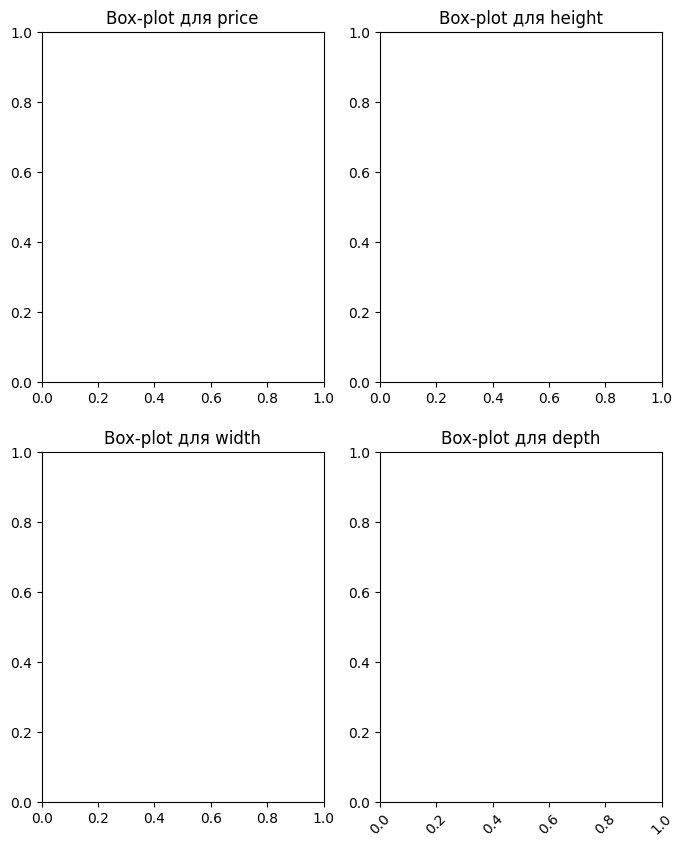

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
i = 0
#plt.figure(figsize=(10, 5))
fig, axs = plt.subplots(2, 2, figsize=(8, 10))
for col in df_numeric.columns:
    j = i % 2
    k = i // 2
    sns.boxplot(data = df_numeric, x = col, ax=axs[k, j]). set_title(f'Box-plot для {col}')
    i += 1


plt.xticks(rotation=45)
plt.show()

Посмотрим на выбросы

Они есть во всех столбцах. 

В столбце price: это вполне логично так как идет смешение люксового и более простого сегментов сумок в зависимости от бренда.

В столбцах height width depth тоже есть вбросы на графике, это закономерно так как возможно это выделяются чемоданы или особенно большие сумки. При этом выбросы есть именно с большей стороны, то есть слишком маленьких значений которые могли бы считаться выбросами нету тут.

In [21]:
df_numeric.hist(bins=30, figsize=(12, 10))
plt.suptitle('Гистограммы распределения переменных')
plt.show()


ValueError: hist method requires numerical or datetime columns, nothing to plot.

Про ассиметрию:

Если смотреть только на графики что можно сказать что симетричное распределение есть у depth (если не считать один выброс справа) и width примерно. Гистограмма выглядит как колокол (нормальное распределение), где среднее, медиана и мода совпадают. Это указывает на отсутствие асимметрии и равномерное распределение данных.

Положительная ассиметрия, то есть на гистограмме наблюдается длинный правый хвост, что указывает на то, что большинство значений сосредоточено в нижней части диапазона, а более высокие значения встречаются реже. Это похоже на графики у price и height

Про островершинность:

Положительную островершинность, то есть более высокую и острую вершину с тяжелыми хвостами, мы можем наблюдать у price и height. Возможно еще у depth Это говорит о том, что данные имеют больше выбросов и экстремальных значений по сравнению с нормальным распределением. 

Отрицательную островершинность, то есть гистограмма выглядит более плоской и широкой, чем нормальное распределение, можно наблюдать у width. Это говорит о том, что данные имеют меньше выбросов по сравнению с нормальным распределением.

In [18]:
skewness = df_numeric.skew()
kurtosis = df_numeric.kurt()

print("Skewness:")
skewness


Skewness:


price     4.783592
height    1.558678
width     0.806900
depth     1.153825
dtype: float64

In [19]:
print("Kurtosis:")
kurtosis

Kurtosis:


price     24.487452
height     3.838491
width      0.598793
depth      3.880968
dtype: float64

Примерно то что мы видели на графикам, мы видим и на числах.

Выводы можно сделать следующие.

Если коэффициент асимметрии положителен, это может указывать на наличие большого числа низких значений в то время как высокие значения, выбросы тянут среднее вверх.
Если коэффициент отрицателен, это может говорить о том, что большинство значений сосредоточено в верхней части диапазона, а низкие значения, выбросы тянут среднее вниз.

Про островершинность: 
Положительное значение указывает на то, что данные имеют тенденцию к большему количеству выбросов.
Отрицательное значение говорит о том, что данные более равномерно распределены и имеют меньше выбросов.

У нас все положительное !

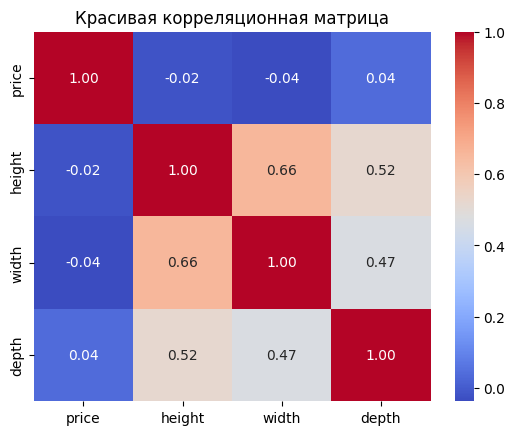

In [20]:
cor_mat = df_numeric.corr()

plt.figure()
sns.heatmap(cor_mat, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Красивая корреляционная матрица')
plt.show()


Общие результаты по матрице корреляций:

Сильная свзять (больше 0.2) не наблидается.

Средняя взяимосвязь (от 0.1 до 0.2) тоже не наблюдается.

Низкая связь (меньше 0.1) у цены со всеми переменными

# Выбор функциональной формы и проверка гипотез

### Скачивание и преобразование

In [3]:
df = pd.read_csv("bags.csv")
df.head(5)

,name,price,brand,color,material,design_country,manufacture_country,article,height,width,...,Параметры изделия для размера 53x78x31,Параметры изделия для размера 44x74x40,Параметры изделия для размера 56x82x32,Параметры изделия для размера 75,Параметры изделия для размера 48x69x28,Параметры изделия для размера 44х71х25,На,Чек,Ек,is_suitcase


In [4]:
translate = {"брелок" : "keychain", "замок" : "lock", "пыльник" : "dust_cover", "зеркало" : "mirror", "второй ремешок" : "second_belt", "косметичка" : "makeup_bag"}
for keyword in ["брелок", "замок", "пыльник", "зеркало", "второй ремешок", "косметичка"]:
    df[translate[keyword]] = df["included_items"].str.contains(keyword).astype(int)

In [9]:
df.sample()

ValueError: a must be greater than 0 unless no samples are taken

Мы не будем брать в качестве признаков название сумки и ее артикль, поскольку это уникальные значения. 

In [10]:
X = df[["brand", "color", "material", "design_country", "manufacture_country", "height", "width", "depth", "is_suitcase", "keychain", "lock", "dust_cover", "mirror", "second_belt", "makeup_bag"]]
y = df["price"]

In [6]:
len(set(df["material"]))

0

OneHotEncode-им качественные признаки. Заметим, что у нас очень много уникальных значений материала. Безусловно, кожа страуса и кожа аллигатора влияют на цену, но, поскольку такие материалы встречаются редко, мы решили объединить их в одну "редкую" категорию. Аналогично поступим со всеми редкими категориями.

### вариант с OneHotEncoder

In [11]:
from sklearn.preprocessing import OneHotEncoder

categorical_cols = ['brand', 'color', 'material', 'design_country', 'manufacture_country']

encoder = OneHotEncoder(handle_unknown='infrequent_if_exist', 
                        min_frequency=20,
                        sparse_output=False) # возвращаем numpy array, а не sparse matrix
encoded_data = encoder.fit_transform(X[categorical_cols])

# Создаем DataFrame с новыми колонками
encoded_df = pd.DataFrame(
    encoded_data,
    columns=encoder.get_feature_names_out(categorical_cols),
    index=X.index
)

encoded_df.drop([col for col in encoded_df.columns if 'infrequent' in col], inplace=True, axis=1)

# Объединяем с исходными данными (исключая старые категориальные колонки)
X_encoded = pd.concat([
    X.drop(columns=categorical_cols),
    encoded_df
], axis=1)
X_encoded['const'] = 1.
X_encoded[X_encoded.columns] = X_encoded[X_encoded.columns].astype(int)

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [8]:
X_encoded

NameError: name 'X_encoded' is not defined

In [28]:
X_encoded.columns

Index(['height', 'width', 'depth', 'is_suitcase', 'keychain', 'lock',
       'dust_cover', 'mirror', 'second_belt', 'makeup_bag', 'brand_Borbonese',
       'brand_Bottega Veneta', 'brand_Coccinelle', 'brand_Dolce & Gabbana',
       'brand_Furla', 'brand_MARC JACOBS (THE)', 'brand_MICHAEL Michael Kors',
       'brand_Sans-Arcidet', 'color_Бежевый', 'color_Голубой',
       'color_Коричневый', 'color_Кремовый', 'color_Светло-бежевый',
       'color_Черный', 'material_Кожа натуральная: 100%',
       'material_Текстиль: 100%', 'design_country_Италия',
       'design_country_США', 'design_country_Соединенное Королевство',
       'design_country_Франция', 'manufacture_country_Вьетнам',
       'manufacture_country_Италия', 'manufacture_country_Камбоджа',
       'manufacture_country_Китай (Китайская Народная Республика)',
       'manufacture_country_Мадагаскар', 'manufacture_country_Тунис', 'const'],
      dtype='object')

In [22]:
X_encoded[X_encoded.columns] = X_encoded[X_encoded.columns].astype(int)
X_encoded['const'] = 1
X_encoded

NameError: name 'X_encoded' is not defined

In [23]:
encoder.categories_

AttributeError: 'OneHotEncoder' object has no attribute 'categories_'

### Линейная модель

In [24]:
def print_model(model):
    s = '\\begin{tabular}{r|c|l}\n\\toprule\n признак & значение & p-value\\\\\n\\midrule\n'
    for feat, value, pvalue in zip(model.params.index, model.params, model.pvalues):
        s += f'{feat.replace(' (Китайская Народная Республика)', '').replace('_', '\\_').replace('%', '\\%').replace('&', '\\&')} & {value:.2f} & {pvalue:.2e} \\\\\n'
    s += '\\bottomrule\n\\end{tabular}'
    print(s)

In [25]:
model = sm.OLS(y, X_encoded).fit()

print(model.summary())

NameError: name 'X_encoded' is not defined

Получилось неплохое значение R^2 = 0.381. F-тест показывает, что На 5% уровне значимости наша модель в целом значима. На этом уровне значимы следующие коэффициенты: keychain, lock, mirror, second_belt, brand_Borbonese, brand_Botteha Veneta, brand_Dolce & Gabbana, brand_MARC JACOBS (THE),
brand_MICHAEL Michael Kors, brand_infrequent_sklearn, color_Черный, material_Кожа натуральная: 100%, material_Текстиль: 100%, material_infrequent_sklearn , manufacture_country_Италия,design_country_Италия, design_country_США, design_country_Соединенное Королевство, design_country_Франция, design_country_infrequent_sklearn, manufacture_country_Китай (Китайская Народная Республика), manufacture_country_Мадагаскар.

Наличие брелка

Все цвета оказались незначимые, что логично: товар часто бывает представлен в разных цветах, отчего его цена не меняется.
Оказались значимы практически все крупные бренды, практически все распространенные страны дизайна сумок и некоторые страны производства.

### Полулогарифмическая модель

In [26]:
log_y = np.log(y)

halflog_model = sm.OLS(log_y, X_encoded).fit()

print(halflog_model.summary())

NameError: name 'X_encoded' is not defined

У полулогарифмической модели получился очень хороший R^2 = 0.690. Модель в целом значима, и значимы оказались многие коэффициенты. На уровне значимости 5% отвергаем гипотезу о значимости height, width, is_suitcase, lock, dust_cover, makeup_bag и brand_Sans-Arcidet , design_country_Соединенное Королевство , design_country_Италия, manufacture_country_Камбоджа, manufacture_country_Тунис. Логично, что некоторые маленькие аксессуары типа зеркальца не влияют на стоимость сумки.

### Линейная в логарифмах модель

Оценим линецную в лоагрифмах модель, которая объясняет логарифм цены логарифмами размера сумки, константой и остальными дамми-признаки.

In [27]:
log_X = X_encoded.copy()
log_X['ln_height'] = np.log(log_X['height'])
log_X['ln_width'] = np.log(log_X['width'])
log_X['ln_depth'] = np.log(log_X['depth'])
log_X.drop(columns=['width', 'depth', 'height'], inplace=True)
log_X.sample()

NameError: name 'X_encoded' is not defined

In [28]:
log_model = sm.OLS(log_y, log_X).fit()

print(log_model.summary())

NameError: name 'log_X' is not defined

R^2 получился на 0.003 лучше, чем у полулогарифмической модели. Из логарифмических объясняющих переменных значимая получилась только ln_depth. В остальном значимы все коэффициенты, кроме is_suitcase, lock, dust_cover, makeup_bag, brand_Sans-Arcidet, material_Кожа натуральная: 100%, design_country_Италия,manufacture_country_Италия, design_country_Соединенное Королевство, manufacture_country_Камбоджа,manufacture_country_Тунис, цветов, ln_height и ln_width.

### Сравнение моделей


R^2 полулогарифмической модели чуть хуже, чем R^2 линейной в логарифмах модели, поэтому юудем сравнивать линейную модель с линейной в логарифмах тестом Бокса-Кокса с преобразованием Зарембки:

$$
H_0: \text{"качество подгонки линейной и полулогарифмической моделей одинаковое"}\\
H_1: \text{"модель с меньшей $RSS'$ лучше"}
$$

$$
\chi^2 = \frac{n}{2}\left|\ln\frac{RSS'_\text{линейный}}{RSS'_\text{полулогарифмический}}\right| \sim \chi^2_1 $$

$$
RSS'_\text{линейный} = 8668.18,\ RSS'_\text{логарифмический} = 217.77,\ \text{p-value} = 0.0$$

Где $RSS'$ - это $RSS$ с целевой переменной, нормированной на геометрическое среднее.
Будем использовать логарифмическую модель, потому что у нее сильно меньше $RSS'$, и по тесту мы отвергаем гипотезу о том, что качество моделей одинаковое.

In [29]:
gY = np.exp(np.mean(np.log(y)))

Y_star = y / gY

linear_model_pred =  sm.OLS(Y_star, X_encoded).fit().predict(X_encoded)
RSS_linear = np.sum(np.square(linear_model_pred - Y_star))

logarithmic_model_pred = sm.OLS(np.log(Y_star), X_encoded).fit().predict(X_encoded)
RSS_logarithmic = np.sum(np.square(logarithmic_model_pred - np.log(Y_star)))

chi_square = X.shape[0]/2*np.abs(np.log(RSS_linear) - np.log(RSS_logarithmic))

p_value = 1 - chi2.cdf(chi_square, 1)

print(f'RSS_linear = {RSS_linear}, RSS_logarithmic = {RSS_logarithmic}, p_value = {p_value}')

NameError: name 'X_encoded' is not defined

### Интерпретация итоговой логарифмической модели


Вот предложения для всех пар по аналогии с первым:  

1. Наличие **чемодана (is_suitcase)** увеличивает цену в $ e^{0.0901} \approx 1.09 $ раз.  
2. Наличие **замка (lock)** увеличивает цену в $ e^{0.5031} \approx 1.65 $ раз.  
3. Наличие **пыльника (dust_cover)** увеличивает цену в $ e^{0.2315} \approx 1.26 $ раз.  
4. Наличие **брелка (keychain)** увеличивает цену в $ e^{0.326285} \approx 1.38 $ раз.  
5. Наличие **зеркала (mirror)** увеличивает цену в $ e^{1.004750} \approx 2.73 $ раз.  
6. Наличие **второго ремня (second_belt)** увеличивает цену в $ e^{0.309583} \approx 1.36 $ раз.  
7. Наличие **косметички (makeup_bag)** увеличивает цену в $ e^{0.0168} \approx 1.02 $ раз.  
8. Бренд **Borbonese** уменьшает цену в $ e^{-0.921914} \approx 0.40 $ раз.  
9. Бренд **Bottega Veneta** увеличивает цену в $ e^{0.901444} \approx 2.46 $ раз.  
10. Бренд **Coccinelle** уменьшает цену в $ e^{-0.621792} \approx 0.54 $ раз.  
11. Бренд **Dolce & Gabbana** увеличивает цену в $ e^{0.578613} \approx 1.78 $ раз.  
12. Бренд **Furla** уменьшает цену в $ e^{-0.578425} \approx 0.56 $ раз.  
13. Бренд **MARC JACOBS (THE)** уменьшает цену в $ e^{-0.714986} \approx 0.49 $ раз.  
14. Бренд **MICHAEL Michael Kors** уменьшает цену в $ e^{-1.721312} \approx 0.18 $ раз.  
15. Бренд **Sans-Arcidet** уменьшает цену в $ e^{-0.165806} \approx 0.85 $ раз.  
16. Цвет **бежевый** увеличивает цену в $ e^{0.109365} \approx 1.12 $ раз.  
17. Цвет **голубой** увеличивает цену в $ e^{0.156121} \approx 1.17 $ раз.  
18. Цвет **коричневый** увеличивает цену в $ e^{0.067140} \approx 1.07 $ раз.  
19. Цвет **кремовый** уменьшает цену в $ e^{-0.032103} \approx 0.97 $ раз.  
20. Цвет **светло-бежевый** уменьшает цену в $ e^{-0.007977} \approx 0.99 $ раз.  
21. Цвет **черный** увеличивает цену в $ e^{0.015548} \approx 1.02 $ раз.  
22. Материал **натуральная кожа (100%)** уменьшает цену в $ e^{-0.000604} \approx 1.00 $ раз (практически не влияет).  
23. Материал **текстиль (100%)** уменьшает цену в $ e^{-0.355305} \approx 0.70 $ раз.  
24. Страна дизайна **Италия** увеличивает цену в $ e^{0.182081} \approx 1.20 $ раз.  
25. Страна дизайна **США** увеличивает цену в $ e^{1.290369} \approx 3.63 $ раз.  
26. Страна дизайна **Соединенное Королевство** увеличивает цену в $ e^{0.223214} \approx 1.25 $ раз.  
27. Страна дизайна **Франция** увеличивает цену в $ e^{0.308532} \approx 1.36 $ раз.  
28. Страна производства **Вьетнам** уменьшает цену в $ e^{-0.578694} \approx 0.56 $ раз.  
29. Страна производства **Италия** увеличивает цену в $ e^{0.936172} \approx 2.55 $ раз.  
30. Страна производства **Камбоджа** уменьшает цену в $ e^{-0.224221} \approx 0.80 $ раз.  
31. Страна производства **Китай** уменьшает цену в $ e^{-0.183101} \approx 0.83 $ раз.  
32. Страна производства **Мадагаскар** уменьшает цену в $ e^{-0.867604} \approx 0.42 $ раз.  
33. Страна производства **Тунис** уменьшает цену в $ e^{-0.232383} \approx 0.79 $ раз.  
34. Константа (const) задает базовую цену: $ e^{10.148609} \approx 25570.35 $.  
35. При увеличении **глубины сумки (ln_depth)** на 1% цена сумки увеличится на 0.16%.

# Проверка предпосылок теоремы Гаусса-Маркова:


Для начала вспомним формулировку самой теоремы:

В модели $y = X\beta + \varepsilon$ оценка коэффициентов методом наименьших квадратов

$$\hat{\beta} = (X'X)^{-1}X'y$$


является **наилучшей линейной несмещённой (BLUE)**, если выполнены следующие предпосылки:


### 1. **Линейность модели**
Модель линейна по параметрам $\beta$:  
$y = X\beta + \varepsilon$


### 2. **Полный ранг матрицы признаков**
Матрица $ X \in \mathbb{R}^{n \times k} $ имеет **полный ранг** ($\text{rank}(X) = k $ )

Иными словами, столбцы матрицы $ X $ — линейно независимы.


### 3. **Несмещённость ошибок**
Ошибки имеют нулевое математическое ожидание:  $\mathbb{E}[\varepsilon] = 0$


### 4. **Гомоскедастичность**
Ошибки имеют одинаковую дисперсию:  
$\text{Var}(\varepsilon_i) = \sigma^2 \quad \forall i \in [1, n]$


### 5. **Попарная некоррелированность ошибок**
Ошибки не коррелированы между собой: $\text{Cov}(\varepsilon_i, \varepsilon_j) = 0, \quad  \forall  i \ne j$  
Иными словами: $\text{Var}(\varepsilon) = \sigma^2 I_n $



---

In [30]:
best_model = log_model

NameError: name 'log_model' is not defined

### 1) Проверим, что данные имеют линейную зависимость $Y = X \beta + \epsilon\$:

Мы задали модель, используя библиотечную функцию $sm.OLS(y, X).fit()$, которая строит линейную модель, подбирая параметры методом наименьших квадратов.

Таким образом, наша модель имеет вид:

$$y_i = \beta_0 + \beta_1 * x_1 + ... + \beta_k*x_k$$

$$\Downarrow$$

$$\text{линейность по параметрам выполняется}$$

### 2) Проверим линейную независимость столцов матрицы признаков:

Для этого посчитаем ранг матрицы и сравним с ее количеством столбцов. Если значения совпадут, то матрица имеет полный ранг.

In [ ]:
rank_X = np.linalg.matrix_rank(log_X)
columns_num = log_X.shape[1]
if rank_X == columns_num:
    print('Матрица имеет полный ранг')
else:
    print('Матрица не имеет полный ранг')

print("ранг:", rank_X)

Матрица имеет полный ранг
ранг: 37


### 3) Проверим, что $E(ϵ) = 0$ (ошибки не смещены)

Основная гипотеза H_0 : $\mathbb{E}[\varepsilon] = 0$

Тогда, альтернативная гипотеза H_1: $\mathbb{E}[\varepsilon] \ne 0$

Для решения задачи используем t-тест:


In [ ]:
residuals = best_model.resid
t_stat, p_value = stats.ttest_1samp(residuals, popmean=0)

print(f"t-статистика: {t_stat:.4f}")
print(f"p-значение: {p_value:.4f}")

t-статистика: -0.0000
p-значение: 1.0000


Тк $\text{p-value} = 1 \Rightarrow$ основная гипотеза не отклоняется $\Rightarrow \mathbb{E}[\varepsilon] = 0$

Нарисуем график распределения ошибок для наглядности:

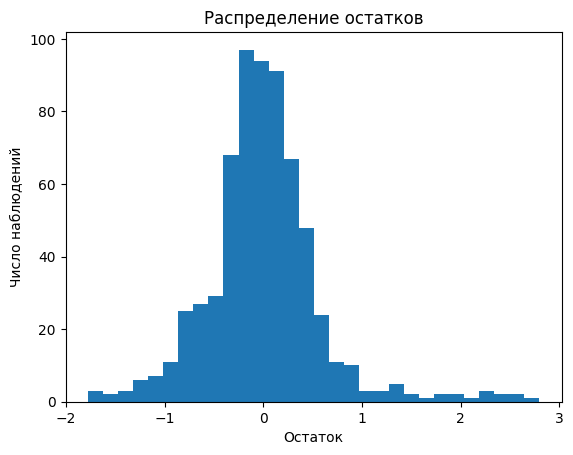

In [ ]:
plt.hist(residuals, bins=30, color='#0f2c68')
plt.title('Распределение остатков')
plt.xlabel('Остаток')
plt.ylabel('Число наблюдений')
plt.show()

Предпосылка верна

### 4) Проверка на гомоскедастичность:

Проведем тест Бреуша–Пагана:

Нулевая гипотеза: $H_0: \operatorname{Var}(\varepsilon_i) = \sigma^2$ (гомоскедастичность).

Альтернативная гипотеза: $H_1: \operatorname{Var}(\varepsilon_i) = \sigma^2 h(z_i), \quad   h(z_i)$, $z_i$ — переменные, влияющие на дисперсию ошибок. Иными словами, присутствует гетероскедастичность

Идея теста: квадраты остатков $\hat{\varepsilon}_i^2$ и регрессируются на признаки модели:
$\hat{\varepsilon}_i^2 = \alpha_0 + \alpha_1 z_{i1} + \dots + \alpha_k z_{ik} + u_i$.

Статистика теста: $LM = n \cdot R^2$, сравнивается с критическим значением распределения $\chi^2_k$.

In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan

test = het_breuschpagan(best_model.resid, best_model.model.exog)
print(f'p-value: {test[1]}')  # если p < 0.05 → гетероскедастичность есть


p-value: 8.09434732436926e-15


Для наглядности построим график в координатах ($\hat y, \text{residuals}$). Если величина остатков будет раполагаться в районе нуля для всех предсказанных значений, то можно говорить о гомоскедастичности.

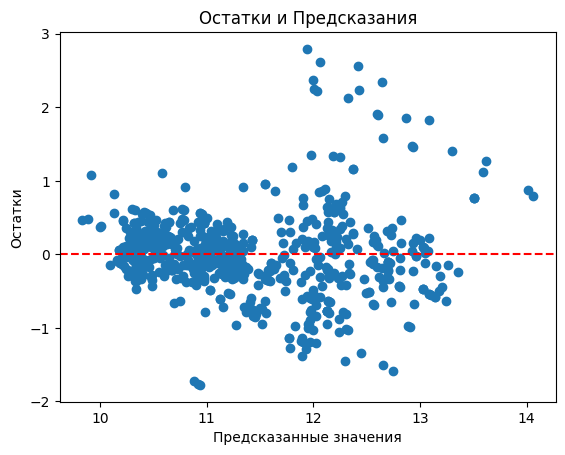

In [ ]:
plt.scatter(best_model.fittedvalues, best_model.resid, color='#0f2c68')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Остатки и Предсказания')
plt.show()


Нетрудно заметить, что в нашей модели присутствует гетероскедастичность. В таком случае оценки коэффициентов останутся несмещёнными, однако стандартные ошибки могут быть искажены. Для корректной статистической интепрпетации используем робастные (устойчивые к гетероскедастичности) стандартные ошибки:

In [ ]:
robust_result = sm.OLS(log_y, log_X).fit(cov_type='HC1')
robust_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     65.28
Date:                Thu, 08 May 2025   Prob (F-statistic):          3.12e-184
Time:                        18:13:44   Log-Likelihood:                -564.70
No. Observations:                 650   AIC:                             1203.
Df Residuals:                     613   BIC:                             1369.
Df Model:                          36                                         
Covariance Type:                  HC1                                         
=============================================================================================================================
                                                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
is_suitcase                                                   0.0901      0.309      0.292      0.770      -0.515       0.695
keychain                                                      0.3263      0.173      1.890      0.059      -0.012       0.665
lock                                                          0.5031      0.479      1.050      0.294      -0.436       1.443
dust_cover                                                    0.2315      0.190      1.216      0.224      -0.142       0.605
mirror                                                        1.0047      0.369      2.721      0.007       0.281       1.729
second_belt                                                   0.3096      0.165      1.872      0.061      -0.015       0.634
makeup_bag                                                    0.0168      0.074      0.228      0.820      -0.128       0.162
brand_Borbonese                                              -0.9219      0.110     -8.346      0.000      -1.138      -0.705
brand_Bottega Veneta                                          0.9014      0.141      6.411      0.000       0.626       1.177
brand_Coccinelle                                             -0.6218      0.071     -8.812      0.000      -0.760      -0.484
brand_Dolce & Gabbana                                         0.5786      0.144      4.010      0.000       0.296       0.861
brand_Furla                                                  -0.5784      0.122     -4.735      0.000      -0.818      -0.339
brand_MARC JACOBS (THE)                                      -0.7150      0.274     -2.609      0.009      -1.252      -0.178
brand_MICHAEL Michael Kors                                   -1.7213      0.272     -6.334      0.000      -2.254      -1.189
brand_Sans-Arcidet                                           -0.1658      0.194     -0.856      0.392      -0.545       0.214
color_Бежевый                                                 0.1094      0.077      1.419      0.156      -0.042       0.260
color_Голубой                                                 0.1561      0.149      1.045      0.296      -0.137       0.449
color_Коричневый                                              0.0671      0.089      0.758      0.449      -0.107       0.241
color_Кремовый                                               -0.0321      0.109     -0.296      0.768      -0.245       0.181
color_Светло-бежевый                                         -0.0080      0.132     -0.060      0.952      -0.267       0.251
color_Черный                                                  0.0155      0.062      0.251      0.802      -0.106       0.137
material_Кожа натуральная: 100%                            

### 5) Проверим отсутствие попарной некоррелированности ошибок:



Для этого используем тест Дарбина-Уотсона.

$$
H_0 : \text{ошибки не автокоррелированы (независимы)} \\
H_1 : \text{ошибки автокоррелированы (зависят от предыдущих)}
$$

Статистика теста считается по следующей формуле:

$$
DW = \frac{\sum\limits_{i=2}^{n} (\varepsilon_i - \varepsilon_{i-1})^2}{\sum\limits_{i=1}^{n} \varepsilon_i^2}
$$

- $ \varepsilon_i $ — остатки регрессии  
- Статистика показывает, насколько ошибки "прыгают" между наблюдениями

Значения теста соответствуют следующим результатам:


| Значение $DW$ | Интерпретация                          |
|---------------|----------------------------------------|
| $ \approx 2 $ | Нет автокорреляции                  |
| $ < 2 $       | Положительная автокорреляция        |
| $ > 2 $       | Отрицательная автокорреляция        |


Чтобы ошибки были некоррелированы между собой, необходимо, чтобы ковариационная матрица имела вид $\text{Var}(\varepsilon) = \sigma^2 I_n$. то есть была диагональной



In [ ]:
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(best_model.resid)
print('Durbin-Watson:', dw_stat)

Durbin-Watson: 1.7153307163727793


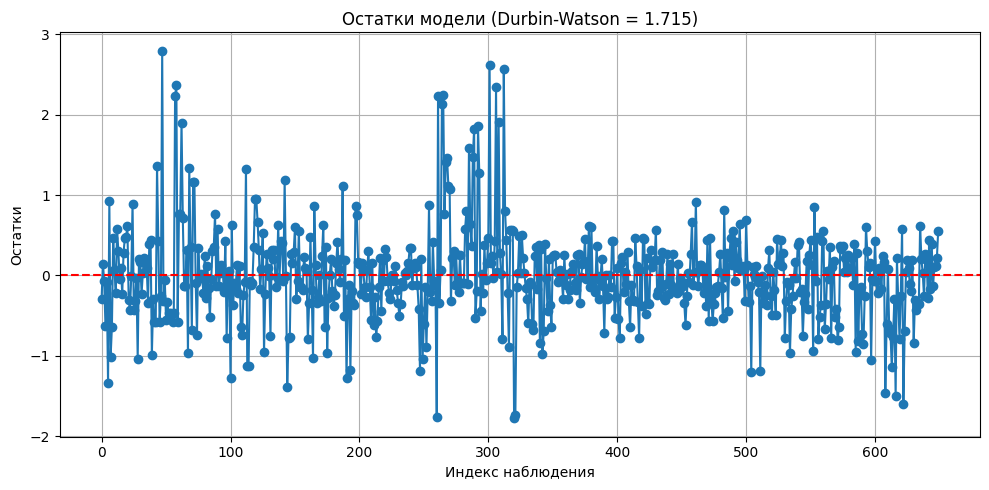

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(best_model
         .resid.values, marker='o', color='#0f2c68')
plt.axhline(0, color='red', linestyle='--')
plt.title(f'Остатки модели (Durbin-Watson = {dw_stat:.3f})')
plt.xlabel('Индекс наблюдения')
plt.ylabel('Остатки')
plt.grid(True)
plt.tight_layout()
plt.show()

Анализ ошибок модели показал умеренную положительную автокорреляцию. Для корректной оценки стандартных ошибок применим робастные оценки, устойчивые к внутригрупповой корреляции.

In [ ]:
robust_cluster = sm.OLS(log_y, log_X).fit().get_robustcov_results(cov_type='cluster',
                                              groups=df['brand'])

print(robust_cluster.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     2483.
Date:                Thu, 08 May 2025   Prob (F-statistic):           5.42e-98
Time:                        18:13:44   Log-Likelihood:                -564.70
No. Observations:                 650   AIC:                             1203.
Df Residuals:                     613   BIC:                             1369.
Df Model:                          36                                         
Covariance Type:              cluster                                         
                                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 36, but rank is 28
  warnings.warn('covariance of constraints does not have full '


# Нормальность случайной ошибки

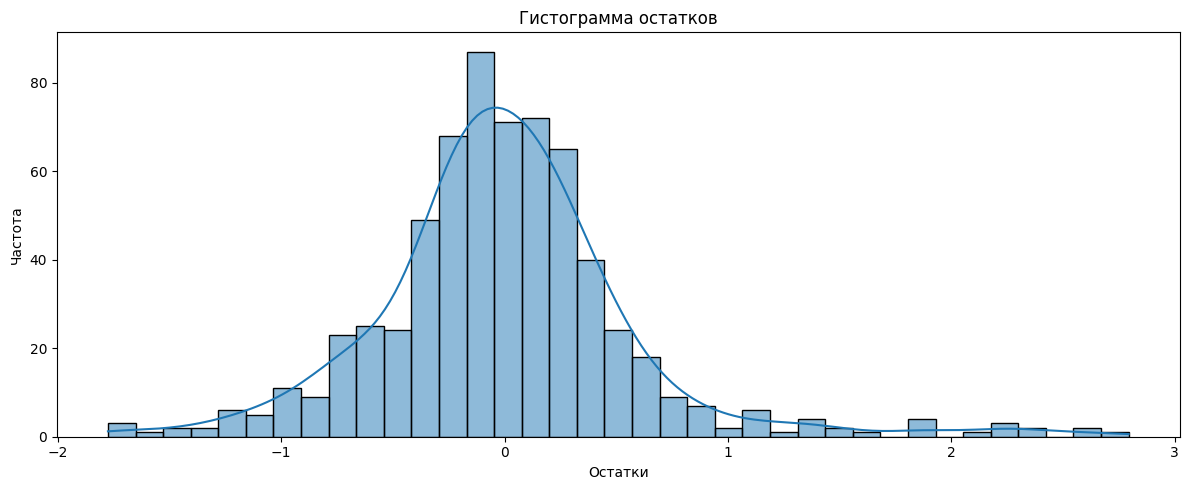

Тест Колмогорова Смирнова на нормальность распределения:
Kolmogorov-Smirnov test: D = 0.0933, p-value = 0.0000
Гипотеза о нормальности не отвергается


In [ ]:
def check_residual_normality(residuals, alpha=0.05):
    
    plt.figure(figsize=(12, 5))
    sns.histplot(residuals, kde=True)
    plt.title('Гистограмма остатков')
    plt.xlabel('Остатки')
    plt.ylabel('Частота')
    
    plt.tight_layout()
    plt.show()
    
    print("Тест Колмогорова Смирнова на нормальность распределения:")
    ks_test = stats.kstest(residuals, 'norm', args=(np.mean(residuals), np.std(residuals)))
    print(f"Kolmogorov-Smirnov test: D = {ks_test.statistic:.4f}, p-value = {ks_test.pvalue:.4f}")
    print(f"Гипотеза о нормальности {'не ' if ks_test.pvalue < alpha else ''}отвергается")

residuals = log_model.resid
check_residual_normality(residuals)

# Своя сумка

У этой THE TOTE BAG не были указаны размеры, поэтому она не попала в итоговый датасет. Попробуем предсказать для нее цену, используя средние лог размеры

In [37]:
print('5547585' in list(df['article']))

False


In [38]:
tote_bag = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, np.mean(log_X[log_X['brand_MARC JACOBS (THE)'] == 1]['ln_height']), np.mean(log_X[log_X['brand_MARC JACOBS (THE)'] == 1]['ln_width']), np.mean(log_X[log_X['brand_MARC JACOBS (THE)'] == 1]['ln_depth'])]

In [39]:
list(zip(log_model.params.index, tote_bag))

[('is_suitcase', 0),
 ('keychain', 0),
 ('lock', 0),
 ('dust_cover', 0),
 ('mirror', 0),
 ('second_belt', 0),
 ('makeup_bag', 0),
 ('brand_Borbonese', 0),
 ('brand_Bottega Veneta', 0),
 ('brand_Coccinelle', 0),
 ('brand_Dolce & Gabbana', 0),
 ('brand_Furla', 0),
 ('brand_MARC JACOBS (THE)', 1),
 ('brand_MICHAEL Michael Kors', 0),
 ('brand_Sans-Arcidet', 0),
 ('color_Бежевый', 0),
 ('color_Голубой', 0),
 ('color_Коричневый', 0),
 ('color_Кремовый', 0),
 ('color_Светло-бежевый', 0),
 ('color_Черный', 1),
 ('material_Кожа натуральная: 100%', 0),
 ('material_Текстиль: 100%', 1),
 ('design_country_Италия', 0),
 ('design_country_США', 1),
 ('design_country_Соединенное Королевство', 0),
 ('design_country_Франция', 0),
 ('manufacture_country_Вьетнам', 0),
 ('manufacture_country_Италия', 0),
 ('manufacture_country_Камбоджа', 1),
 ('manufacture_country_Китай (Китайская Народная Республика)', 0),
 ('manufacture_country_Мадагаскар', 0),
 ('manufacture_country_Тунис', 0),
 ('const', 1),
 ('ln_heigh

In [62]:
p1 = log_model.predict(tote_bag).item()
p1

10.751224863910025

In [63]:
print("Предсказанная цена THE TOTE BAG:", np.exp(p1))

Предсказанная цена THE TOTE BAG: 46687.17888610645


А теперь предскажем цену авторской сумки, которая еще не появилась на рынке. Дизайнер вдохновлялся, делая проект по эконометрике и кушая клубнику. Посмотреть ее можно в моем личном архиве [(если интересно)))](https://drive.google.com/file/d/1u4wAutn89AIb2TFpMHZ6rJeWmCE8P8-W/view?usp=sharing)

In [53]:
crocodile_bag = [
    0,  # is_suitcase
    1,  # keychain
    1,  # lock
    1,  # dust_cover
    1,  # mirror
    0,  # second_belt
    0,  # makeup_bag
    0,  # brand_Borbonese
    0,  # brand_Bottega Veneta
    0,  # brand_Coccinelle
    0,  # brand_Dolce & Gabbana
    0,  # brand_Furla
    0,  # brand_MARC JACOBS (THE)
    0,  # brand_MICHAEL Michael Kors
    0,  # brand_Sans-Arcidet
    0,  # color_Бежевый
    0,  # color_Голубой
    0,  # color_Коричневый
    0,  # color_Кремовый
    0,  # color_Светло-бежевый
    0,  # color_Черный
    1,  # material_Кожа натуральная: 100%
    0,  # material_Текстиль: 100%
    1,  # design_country_Италия
    0,  # design_country_США
    0,  # design_country_Соединенное Королевство
    0,  # design_country_Франция
    0,  # manufacture_country_Вьетнам
    0,  # manufacture_country_Италия
    0,  # manufacture_country_Камбоджа
    0,  # manufacture_country_Китай (Китайская Народная Республика)
    0,  # manufacture_country_Мадагаскар
    0,  # manufacture_country_Тунис
    1,  # const
    2.8,  # ln_height
    3.6,  # ln_width
    2.5   # ln_depth
]


In [64]:
p2 =log_model.predict(crocodile_bag).item()
p2

13.033382552130359

In [59]:
print("Цена авторской сумки:", np.exp(p2))

Цена авторской сумки: 457431.5578279334


# Квантильная регрессия

In [ ]:

np.random.seed(1001)
quantiles = [0.1, 0.5, 0.9]
for q in quantiles:
    model = sm.QuantReg(log_y, log_X).fit(q=q, vcov='iid')
    print(f"\n=== Результаты квантильной регрессии для квантиля {q} ===\n")
    print(model.summary())
    print("\n" + "="*80 + "\n")



=== Результаты квантильной регрессии для квантиля 0.1 ===

                         QuantReg Regression Results                          
Dep. Variable:                  price   Pseudo R-squared:               0.4464
Model:                       QuantReg   Bandwidth:                      0.2091
Method:                 Least Squares   Sparsity:                        1.244
Date:                Thu, 08 May 2025   No. Observations:                  650
Time:                        20:22:29   Df Residuals:                      613
                                        Df Model:                           36
                                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
is_suitcase                                                  -0.3267      0.138     -2.363      0.018      -0.598      -0.055
keychain 

c:\Users\fedor\Documents\Study\Эконометрика\проект_сумки\.venv\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +



=== Результаты квантильной регрессии для квантиля 0.5 ===

                         QuantReg Regression Results                          
Dep. Variable:                  price   Pseudo R-squared:               0.5175
Model:                       QuantReg   Bandwidth:                      0.1838
Method:                 Least Squares   Sparsity:                       0.7149
Date:                Thu, 08 May 2025   No. Observations:                  650
Time:                        20:22:30   Df Residuals:                      613
                                        Df Model:                           36
                                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
is_suitcase                                                  -0.1683      0.132     -1.271      0.204      -0.428       0.092
keychain 

### Анализ результатов квантильной регрессии для разных квантилей

Общие показатели моделей
- Для q=0.1 (нижний квантиль):
  - Pseudo R² = 0.446 (модель объясняет ~45% вариации)
  - Наиболее значимые факторы: наличие зеркала, бренды (Bottega Veneta, Coccinelle), кожаный материал 

- Для q=0.5 (медиана):
  - Pseudo R² = 0.518 (лучше объясняющая способность)
  - Ключевые драйверы: производство в Италии, бренд Bottega Veneta, натуральная кожа 

- Для q=0.9 (верхний квантиль):
  - Pseudo R² = 0.570 (наивысший)
  - Сильнее всего влияют: производство в Италии, текстильный материал, бренд Borbonese 


Наблюдаемые закономерности:

Бренды:
- Bottega Veneta стабильно повышает цену на всех квантилях 
- Эффект бренда ослабевает для премиум-сегмента (q=0.9) у  Bottega Veneta, Dolce & Gabbana

Материалы:
- Натуральная кожа:
  - Положительный эффект снижается с ростом квантиля
  - Для дорогих сумок (q=0.9) становится негативным фактором

Страна производства:
- Италия:
  - Максимальный эффект для премиума (для q=0.9)
- Китай/Вьетнам:
  - Негативное влияние усиливается для медианы (q=0.5)


Неожиданные эффекты
- Чемоданные модели (is_suitcase):
  - Снижают цену на нижних квантилях, но повышают для премиума
- Размеры (ln_height, ln_width):
  - Высота значима для q=0.1-0.5, но не для q=0.9.
  - Глубина (ln_depth) значима на всех квантилях.



In [ ]:
from tqdm import tqdm
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf

# Устанавливаем seed для воспроизводимости
np.random.seed(1001)

# Параметры анализа
quantiles_mq = [0.1, 0.5, 0.75, 0.9]
models_mq = []  # здесь будем хранить финальные модели с правильными SE
n_boot = 100
predictors = log_X.columns

# Бутстрэп-процедура
print("Запуск бутстрэп-процедуры...")
bootstrap_coefs = {q: [] for q in quantiles_mq}
for _ in tqdm(range(n_boot), desc="Прогресс"):

    bootstrap_sample_X = log_X.sample(n=len(log_X), replace=True)
    bootstrap_sample_y = log_y[bootstrap_sample_X.index]
    for q in quantiles_mq:
        model = sm.QuantReg(bootstrap_sample_y, bootstrap_sample_X).fit(q=q)
        bootstrap_coefs[q].append(model.params)

for q in quantiles_mq:
    # Основная модель
    main_model = sm.QuantReg(log_y, log_X).fit(q=q)

    # Рассчитываем бутстрап-стандартные ошибки
    coefs = pd.DataFrame(bootstrap_coefs[q])
    bse = coefs.std()

    # Создаем новую модель с бутстрап-SE
    main_model.bse = bse  # перезаписываем стандартные ошибки
    models_mq.append(main_model)

# Функция для создания красивой таблицы
def create_results_table(q):
    main_model = sm.QuantReg(log_y, log_X).fit(q=q)
    coefs_df = pd.DataFrame(bootstrap_coefs[q])
    bse = coefs_df.std()

    results = pd.DataFrame({
        'factor': log_X.columns,
        'coeff': [main_model.params[p] for p in predictors],
        'std err (boot)': [bse[p] for p in predictors],
        '95% CI low': [main_model.params[p] - 1.96*bse[p] for p in predictors],
        '95% CI high': [main_model.params[p] + 1.96*bse[p] for p in predictors],
        't-stat': [main_model.params[p]/bse[p] for p in predictors],
        'p-value': [2*(1-stats.norm.cdf(abs(main_model.params[p]/bse[p]))) for p in predictors]
    })

    # Форматирование чисел
    for col in results.columns[1:]:
        results[col] = results[col].apply(lambda x: f"{x:.4f}" if isinstance(x, (int, float)) else x)

    return results

# Вывод результатов для каждого квантиля
for q in quantiles_mq:
    print(f"\n{'='*80}")
    print(f"=== Результаты квантильной регрессии для квантиля {q} (бутстрэп, n={n_boot}) ===")
    print(f"{'='*80}\n")

    results_table = create_results_table(q)
    display(results_table)
     


=== Результаты квантильной регрессии для квантиля 0.1 (бутстрэп, n=100) ===



,factor,coeff,std err (boot),95% CI low,95% CI high,t-stat,p-value
0,is_suitcase,-0.3267,0.2556,-0.8276,0.1743,-1.2781,0.2012
1,keychain,0.0288,0.2326,-0.4270,0.4847,0.1239,0.9014
2,lock,0.1313,0.2953,-0.4475,0.7100,0.4446,0.6566
3,dust_cover,0.0673,0.1583,-0.2428,0.3775,0.4255,0.6705
4,mirror,1.2667,0.5607,0.1678,2.3656,2.2593,0.0239
5,second_belt,0.2676,0.2191,-0.1619,0.6971,1.2211,0.2220
6,makeup_bag,0.0328,0.1313,-0.2246,0.2901,0.2496,0.8029
7,brand_Borbonese,-0.4772,0.1191,-0.7107,-0.2436,-4.0048,0.0001
8,brand_Bottega Veneta,1.1061,0.1227,0.8656,1.3465,9.0154,0.0000
9,brand_Coccinelle,-0.6801,0.0819,-0.8407,-0.5195,-8.3016,0.0000



=== Результаты квантильной регрессии для квантиля 0.5 (бутстрэп, n=100) ===



,factor,coeff,std err (boot),95% CI low,95% CI high,t-stat,p-value
0,is_suitcase,-0.1683,0.6800,-1.5010,1.1645,-0.2474,0.8046
1,keychain,0.1297,0.1145,-0.0948,0.3542,1.1325,0.2574
2,lock,0.3405,0.5651,-0.7671,1.4482,0.6026,0.5468
3,dust_cover,0.2633,0.1656,-0.0613,0.5879,1.5898,0.1119
4,mirror,0.8064,0.5027,-0.1789,1.7917,1.6041,0.1087
5,second_belt,0.1813,0.0755,0.0334,0.3293,2.4018,0.0163
6,makeup_bag,-0.0537,0.0732,-0.1972,0.0898,-0.7331,0.4635
7,brand_Borbonese,-0.6587,0.1152,-0.8844,-0.4329,-5.7193,0.0000
8,brand_Bottega Veneta,1.1282,0.1315,0.8704,1.3859,8.5791,0.0000
9,brand_Coccinelle,-0.4156,0.0670,-0.5468,-0.2843,-6.2067,0.0000



=== Результаты квантильной регрессии для квантиля 0.75 (бутстрэп, n=100) ===



,factor,coeff,std err (boot),95% CI low,95% CI high,t-stat,p-value
0,is_suitcase,0.7879,0.5902,-0.3689,1.9446,1.3350,0.1819
1,keychain,0.2275,0.1691,-0.1039,0.5589,1.3457,0.1784
2,lock,0.2329,0.9877,-1.7029,2.1687,0.2358,0.8136
3,dust_cover,0.4647,0.2277,0.0185,0.9109,2.0411,0.0412
4,mirror,1.6916,0.6528,0.4122,2.9711,2.5914,0.0096
5,second_belt,0.1601,0.0864,-0.0093,0.3295,1.8523,0.0640
6,makeup_bag,-0.0190,0.0860,-0.1875,0.1495,-0.2211,0.8250
7,brand_Borbonese,-1.1261,0.1405,-1.4015,-0.8506,-8.0126,0.0000
8,brand_Bottega Veneta,0.6471,0.2147,0.2262,1.0679,3.0134,0.0026
9,brand_Coccinelle,-0.6504,0.1084,-0.8628,-0.4381,-6.0030,0.0000



=== Результаты квантильной регрессии для квантиля 0.9 (бутстрэп, n=100) ===



,factor,coeff,std err (boot),95% CI low,95% CI high,t-stat,p-value
0,is_suitcase,0.5658,0.4552,-0.3265,1.4581,1.2429,0.2139
1,keychain,0.6794,0.3485,-0.0036,1.3624,1.9496,0.0512
2,lock,0.5981,0.7611,-0.8937,2.0899,0.7859,0.4320
3,dust_cover,0.4381,0.3256,-0.2000,1.0762,1.3458,0.1784
4,mirror,0.8036,0.5231,-0.2217,1.8290,1.5362,0.1245
5,second_belt,0.0959,0.2989,-0.4900,0.6818,0.3208,0.7484
6,makeup_bag,-0.0701,0.1051,-0.2761,0.1360,-0.6664,0.5052
7,brand_Borbonese,-1.3849,0.2373,-1.8501,-0.9198,-5.8356,0.0000
8,brand_Bottega Veneta,0.5522,0.4426,-0.3153,1.4197,1.2477,0.2122
9,brand_Coccinelle,-0.7085,0.1337,-0.9704,-0.4465,-5.3010,0.0000


Изменения в эффектах (бутстрэп по сравнению с исходной моделью)

Устойчивые эффекты (подтвержденные бутстрэпом):
- Бренды:
   - Bottega Veneta: стабильно положительный на всех квантилях (p<0.01)
   - MICHAEL Michael Kors: устойчиво отрицательный (p<0.05)

- Производство:
   - Италия: CI не включает 0 на всех квантилях
   - Мадагаскар: значимо отрицательный эффект для q=0.5 и q=0.9

Неустойчивые эффект:
- Чемоданы:
  - В исходной модели: +0.57 (q=0.9)*
  - В бутстрэпе: CI включает 0 [-0.33, 1.46] → эффект нестабилен

- Размеры (ln_height):
  - Для q=0.1: исходный p=0.005 → бутстрэп p=0.248 то есть эффект исчезает при учете вариативности данных

- Натуральная кожа:
   - Для q=0.9: исходный p<0.001 → бутстрэп p=0.144 то есть в премиум-сегменте эффект материала не подтверждается


Бутстрэп-анализ выявил существенную нестабильность эффектов для части переменных. Ключевые показатели цены (итальянское производство, премиальные бренды) подтвердили свою устойчивость а дизайнерские и цветовые факторы требуют дополнительного исследования

In [ ]:
# Тест на равенство коэффициентов в моделях разных квантилей
# H0: [q10]param = [q90]param
from scipy import stats

# Получаем коэффициенты и их стандартные ошибки для enroll
coef_01 = models_mq[0].params['ln_height']  # для q=0.1
coef_09 = models_mq[2].params['ln_height']  # для q=0.9

se_01 = pd.DataFrame(bootstrap_coefs[0.1]).std()['ln_height']  # стандартная ошибка для q=0.1
se_09 = pd.DataFrame(bootstrap_coefs[0.9]).std()['ln_height']  # стандартная ошибка для q=0.9

# Вычисляем разность коэффициентов и её стандартную ошибку
diff = coef_01 - coef_09
se_diff = np.sqrt(se_01**2 + se_09**2)  # стандартная ошибка разности

# Вычисляем статистику Вальда
wald_stat = diff / se_diff
p_value = 2 * (1 - stats.norm.cdf(abs(wald_stat)))  # двусторонний тест

# Выводим результаты теста
print("\nТест равенства коэффициентов при ln_height для квантилей 0.1 и 0.9:")
print(f"Коэффициент для q=0.1: {coef_01:.4f} (std err: {se_01:.4f})")
print(f"Коэффициент для q=0.9: {coef_09:.4f} (std err: {se_09:.4f})")
print(f"Разность коэффициентов: {diff:.4f} (std err: {se_diff:.4f})")
print(f"Wald statistic: {wald_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Интерпретация результата
alpha = 0.05
if p_value < alpha:
    print(f"\nЗаключение: Отвергаем нулевую гипотезу (p={p_value:.4f} < {alpha}). Коэффициенты статистически значимо различаются.")
else:
    print(f"\nЗаключение: Не отвергаем нулевую гипотезу (p={p_value:.4f} >= {alpha}). Нет доказательств различия коэффициентов.")
     


Тест равенства коэффициентов при ln_height для квантилей 0.1 и 0.9:
Коэффициент для q=0.1: 0.1661 (std err: 0.1437)
Коэффициент для q=0.9: 0.1495 (std err: 0.1120)
Разность коэффициентов: 0.0167 (std err: 0.1822)
Wald statistic: 0.0916
P-value: 0.9270

Заключение: Не отвергаем нулевую гипотезу (p=0.9270 >= 0.05). Нет доказательств различия коэффициентов.


Проведем тест Вальда для всех переменных на значимое разлицие коэффициентов для разных квантилей

$$
H0: [q = 0.1]param.coef = [q= 0.9]param.coef
$$
для каждого параметра

In [ ]:
import pandas as pd
from scipy import stats

def compare_quantile_coefficients(models, bootstrap_coefs, q1=0, q2=2, alpha=0.05):
    variables = log_X.columns
    
    results = []
    
    for var in variables:
        coef1 = models[q1].params[var]
        coef2 = models[q2].params[var]
        
        se1 = pd.DataFrame(bootstrap_coefs[0.1]).std()[var]
        se2 = pd.DataFrame(bootstrap_coefs[0.9]).std()[var]
        
        diff = coef1 - coef2
        se_diff = np.sqrt(se1**2 + se2**2)
        wald_stat = diff / se_diff
        p_value = 2 * (1 - stats.norm.cdf(abs(wald_stat)))
        
        significant = "Да" if p_value < alpha else "Нет"
        
        results.append({
            'Переменная': var,
            f'Коэф. (q={q1})': coef1,
            f'Ст. ошибка (q={q1})': se1,
            f'Коэф. (q={q2})': coef2,
            f'Ст. ошибка (q={q2})': se2,
            'Разность': diff,
            'Ст. ошибка разности': se_diff,
            'Wald stat': wald_stat,
            'P-value': p_value,
            'Отвергаем H0': significant
        })
    
    df_results = pd.DataFrame(results)
    
    df_results = df_results.sort_values('P-value')
    
    return df_results

results_table = compare_quantile_coefficients(models_mq, bootstrap_coefs, q1=0, q2=2)
display(results_table)


,Переменная,Коэф. (q=0),Ст. ошибка (q=0),Коэф. (q=2),Ст. ошибка (q=2),Разность,Ст. ошибка разности,Wald stat,P-value,Отвергаем H0
28,manufacture_country_Италия,0.539116,0.126544,1.114474e+00,0.122265,-0.575359,0.175961,-3.269810,0.001076,Да
7,brand_Borbonese,-0.477161,0.119147,-1.126072e+00,0.237326,0.648911,0.265556,2.443598,0.014542,Да
13,brand_MICHAEL Michael Kors,-0.765692,0.259264,-2.245232e+00,0.562484,1.479540,0.619359,2.388824,0.016902,Да
0,is_suitcase,-0.326659,0.255578,7.878710e-01,0.455239,-1.114530,0.522075,-2.134809,0.032777,Да
25,design_country_Соединенное Королевство,0.547305,0.288467,-1.589936e-01,0.176457,0.706298,0.338157,2.088669,0.036738,Да
33,const,8.757724,0.417713,1.027361e+01,0.661926,-1.515886,0.782707,-1.936722,0.052779,Нет
12,brand_MARC JACOBS (THE),-0.136557,0.337836,-1.462944e+00,0.615697,1.326387,0.702293,1.888651,0.058939,Нет
17,color_Коричневый,0.209437,0.087397,-1.033326e-02,0.111432,0.219770,0.141616,1.551872,0.120693,Нет
24,design_country_США,0.590052,0.434448,1.592581e+00,0.557301,-1.002529,0.706633,-1.418741,0.155974,Нет
35,ln_width,0.227813,0.135107,-2.426889e-02,0.137261,0.252082,0.192599,1.308842,0.190588,Нет


Анализ теста Вальда на значимые различия коэффициентов между квантилями


Найдены статистически значимые различия для 5 переменных:

1. manufacture_country_Италия (p=0.001): коэффициент увеличивается с +0.54 (q=0.1) до +1.11 (q=0.75) то есть влияние итальянского производства усиливается для более дорогих сумок

2. brand_Borbonese (p=0.015): эффект усиливается с -0.48 до -1.13 то есть наблюдается негативное влияние бренда на цену возрастает в премиум-сегменте

3. brand_MICHAEL Michael Kors (p=0.017): коэффициент падает с -0.77 до -2.25, отрицательное влияние усиливается в 3 раза для верхних квантилей

4. is_suitcase (p=0.033): тут инверсия знака -0.33 → +0.79, чемоданные модели снижают цену в массовом сегменте но повышают в премиумном

5. design_country_Соединенное Королевство (p=0.037): тут тоже положительный эффект (+0.55) сменяется отрицательным (-0.16)


### Построим графики для каждого предиката

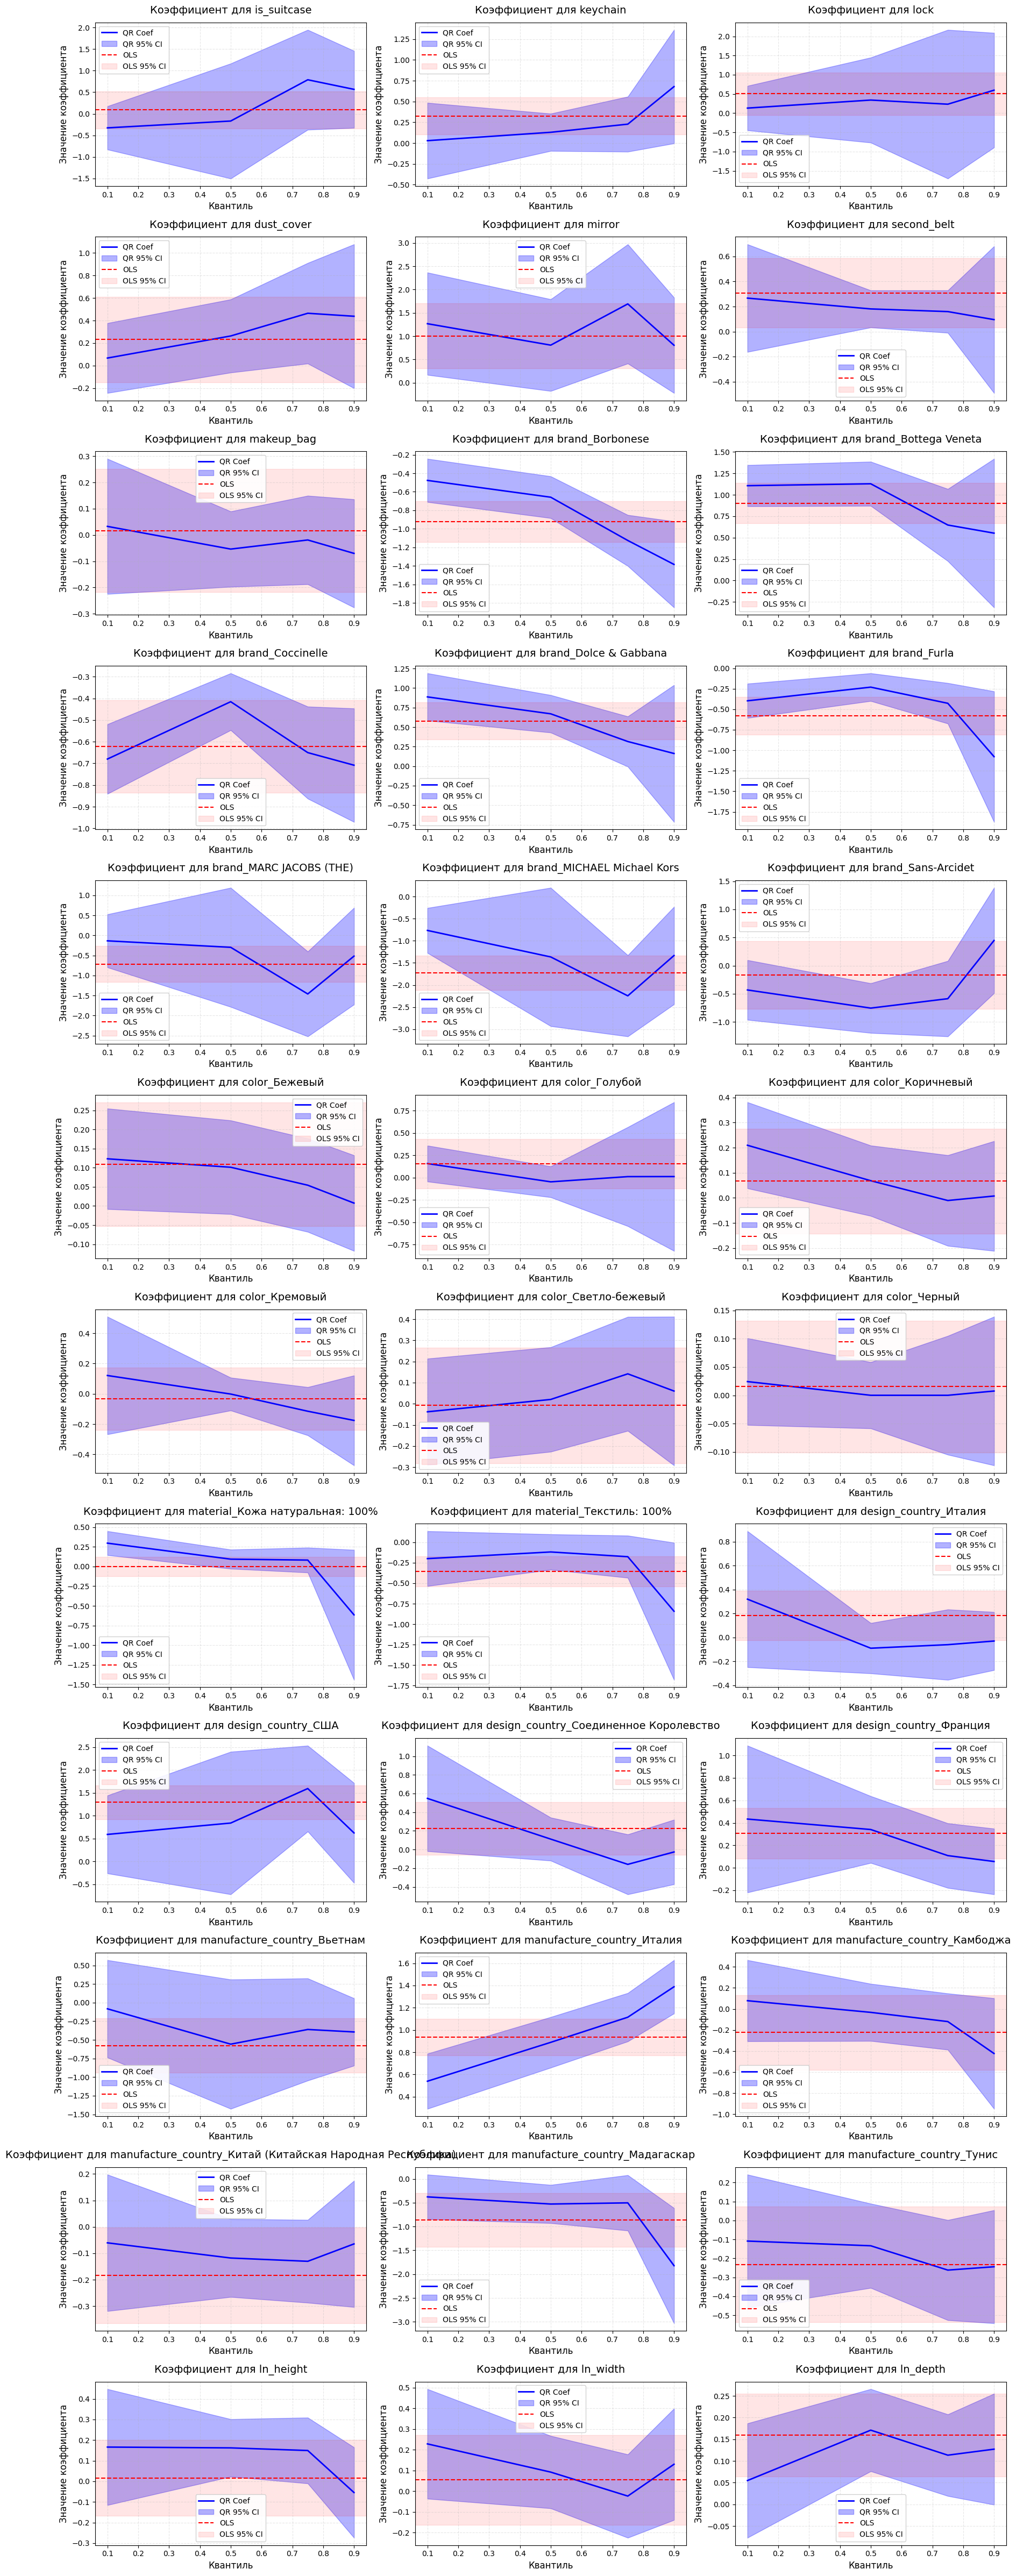

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_quantile_regression_results(models_mq, quantiles_mq, ols_model, ols_conf_int):
    features = [name for name in log_X.columns 
                if name.lower() != 'const']
    
    plot_data = pd.DataFrame({'quantile': quantiles_mq})
    
    for feat in features:
        plot_data[feat] = [models_mq[q].params[feat] for q in range(len(quantiles_mq))]
        plot_data[f'{feat}_lower'] = [models_mq[q].params[feat] - 1.96 * models_mq[q].bse[feat] 
                                     for q in range(len(quantiles_mq))]
        plot_data[f'{feat}_upper'] = [models_mq[q].params[feat] + 1.96 * models_mq[q].bse[feat] 
                                     for q in range(len(quantiles_mq))]
    
    # Добавляем intercept если он есть в модели
    if 'Intercept' in models_mq[0].params.index:
        plot_data['Intercept'] = [models_mq[q].params['Intercept'] for q in range(len(quantiles_mq))]
        plot_data['Intercept_lower'] = [models_mq[q].params['Intercept'] - 1.96 * models_mq[q].bse['Intercept'] 
                                      for q in range(len(quantiles_mq))]
        plot_data['Intercept_upper'] = [models_mq[q].params['Intercept'] + 1.96 * models_mq[q].bse['Intercept'] 
                                      for q in range(len(quantiles_mq))]
        features.append('Intercept')
    
    n_features = len(features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    # Создаем сетку графиков
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))
    axes = axes.flatten()
    
    # Строим графики для каждого признака
    for i, feat in enumerate(features):
        ax = axes[i]
        
        # Название признака для OLS (Intercept может называться по-другому)
        ols_feat_name = feat if feat != 'Intercept' else 'Intercept'
        
        # Квантильная регрессия
        sns.lineplot(data=plot_data, x='quantile', y=feat, ax=ax,
                    label='QR Coef', linewidth=2, color='blue')
        ax.fill_between(plot_data['quantile'],
                       plot_data[f'{feat}_lower'],
                       plot_data[f'{feat}_upper'],
                       alpha=0.3, color='blue', label='QR 95% CI')
        
        # OLS для сравнения
        if ols_feat_name in ols_model.params:
            ax.axhline(ols_model.params[ols_feat_name],
                      color='red', linestyle='--',
                      linewidth=1.5, label='OLS')
            ax.axhspan(ols_conf_int.loc[ols_feat_name, 0],
                      ols_conf_int.loc[ols_feat_name, 1],
                      color='red', alpha=0.1, label='OLS 95% CI')
        
        # Настройки графика
        ax.set_title(f'Коэффициент для {feat}', fontsize=14, pad=12)
        ax.set_xlabel('Квантиль', fontsize=12)
        ax.set_ylabel('Значение коэффициента', fontsize=12)
        ax.legend(fontsize=10, framealpha=0.9)
        ax.grid(True, linestyle='--', alpha=0.3)
    
    # Удаляем лишние оси
    for j in range(len(features), len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()
    
    return plot_data

# Пример использования:
plot_data = plot_quantile_regression_results(models_mq, quantiles_mq, log_model, log_model.conf_int())